**классификатор текстов CONV1D**

Евгений Борисов <borisov.e@solarl.ru>

https://habr.com/ru/company/dca/blog/274027/    
http://help.sentiment140.com/for-students/   
http://study.mokoron.com  

## Библиотеки

In [4]:
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 200  
import re
# import gzip
from tqdm import tqdm

In [5]:
tqdm.pandas()

In [6]:
def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Данные

In [7]:
ff = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount','unk']

In [8]:
neg = pd.read_csv('../data/twit/negative.csv.gz',sep=';',header=None)
ppr(neg)
neg.columns = ff

записей: 111 923


In [9]:
pos = pd.read_csv('../data/twit/positive.csv.gz',sep=';')
ppr(pos)
pos.columns = ff

записей: 114 910


In [10]:
data = pd.concat([pos,neg],sort=False)[['id','ttext', 'ttype']]
ppr(data)

записей: 226 833


In [11]:
data.sample(10)

,id,ttext,ttype
80961,410751232681463808,"Зашла вот ко мне,у меня тут ключицы торчат и все остальное:D",1
39839,409902392495583232,"Я слышу хлопки из актового зала, наверно они на конкурсе чтецов)",1
65118,417140230463176705,Вчера отожгли так что аж сегодня ножки болят;(,-1
85716,410798499136299008,А давайте все будем смотреть фильмы про лесбиянок?))),1
23885,409503190116478976,"Случайно прочитал вывеску ""купля-продажа недвижимости"" как ""купля-продажа ненависти"". Эх, жуйк, что ты со мной сделал :)",1
67967,410397975819866112,"Заставила детей принести мне лавочку,самой то мне лень)",1
62888,410343274335846400,письмо Стасу и небольшой презент для моего Ангела:) http://t.co/RtBaPI0N3n,1
39475,409898335558844419,"@laowaicast как-то проводила конкурс в жж, что же это я съела. Угадали только с подсказки :) http://t.co/oJTGZbf8lH http://t.co/GnaKJHgWDn",1
20832,411660416540876800,"время идёт, а скилл не прокачивается =(: портреты by Marchello http://t.co/FfT3Nc1nlh",-1
59612,410140761028845570,"RT @Calunn5S0S: @jess_calm но я же люблю облизывать шеи :D я съел твою шею,омг.",1


## очистка данных

In [12]:
data['ttext_clean'] = data['ttext']\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t:[ re.sub(r'^http.*',' url ', w.strip() ) for w in t ] )\
    .progress_apply(lambda t:[ re.sub(r'[:;]-*[)D]',' happysmile ', w.strip() )for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\)\)\)*',' happysmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'[:;]\*',' kisssmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r':\(',' sadsmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\(\(\(*',' sadsmile ', w.strip() ) for w in t ])

100%|██████████| 226833/226833 [00:01<00:00, 119467.94it/s]


In [13]:
data['ttext_clean'] = [ ' '.join(s) for s in data['ttext_clean'] ]

In [14]:
data['ttext_clean'] = data['ttext_clean'].str.lower()\
    .progress_apply(lambda s: re.sub( r'\W', ' ', s))\
    .progress_apply(lambda s: re.sub( r'_', ' ', s))\
    .progress_apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s))\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t: [w for w in t if not re.match( r'\b.*\d+.*\b', w) ])

100%|██████████| 226833/226833 [00:02<00:00, 104498.58it/s]


In [15]:
data.sample(3)

,id,ttext,ttype,ttext_clean
68963,417515817639505921,@tergelsar3 Чиний аватар шиг л зураг :P Даанч өөрийнх чинь биш юмоо :(,-1,"[чиний, аватар, шиг, л, зураг, p, даанч, өөрийнх, чинь, биш, юмоо, sadsmile]"
45508,409986552652365824,доброе утро надо начинать с панк-рока :) спасибо тебе!,1,"[доброе, утро, надо, начинать, с, панк, рока, happysmile, спасибо, тебе]"
49143,415072495427805184,"Быть счастливым это круто, но откуда мне знать(",-1,"[быть, счастливым, это, круто, но, откуда, мне, знать]"


In [16]:
# удаление коротких слов
data['ttext_clean'] = data['ttext_clean'].progress_apply(lambda t:[w for w in t if len(w)>2])

100%|██████████| 226833/226833 [00:00<00:00, 358028.86it/s]


In [17]:
ppr(data)
data = data[ data['ttext_clean'].str.len()>0 ].reset_index(drop=True) 
ppr(data)

записей: 226 833
записей: 226 831


In [18]:
data.sample(3)

,id,ttext,ttype,ttext_clean
35672,409777538589016064,"@vladislav735 в городе с клубами напряженка. Потусить, зачем еще :)",1,"[городе, клубами, напряженка, потусить, зачем, еще, happysmile]"
54461,410074125839761408,@my_lyubasha какой маленький ? ахахах все в порядке ),1,"[lyubasha, какой, маленький, ахахах, все, порядке]"
97232,411039550270476288,"@esken_h @spina_putina триедин?.Привет, Кешик:) Какая сегодня основная засада дня? Послание Путиным народа?",1,"[esken, spina, putina, триедин, привет, кешик, happysmile, какая, сегодня, основная, засада, дня, послание, путиным, народа]"


In [19]:
voc = sorted(set.union(*[ set(s) for s in data['ttext_clean'].values.tolist() ]))
voc = { w:i+1 for i,w in enumerate(voc) }
voc['<pad>']= 0
ppr(voc)

записей: 239 518


In [20]:
voc

{'aaa': 1,
 'aaaa': 2,
 'aaaaa': 3,
 'aaaaaaaaaa': 4,
 'aaaaaaaaaaart': 5,
 'aaaaaahhhhhhwow': 6,
 'aaaasyaaa': 7,
 'aaaats': 8,
 'aaahaahaaaah': 9,
 'aaaidar': 10,
 'aaaiguuul': 11,
 'aaakristya': 12,
 'aaalsusha': 13,
 'aaarrrrrrrr': 14,
 'aaaw': 15,
 'aaburnashov': 16,
 'aafrolova': 17,
 'aakarimova': 18,
 'aakellah': 19,
 'aakuzichev': 20,
 'aaleksandra': 21,
 'aaleksandrowna': 22,
 'aalello': 23,
 'aalexithymiaa': 24,
 'aalistok': 25,
 'aalive': 26,
 'aallanavaz': 27,
 'aalove': 28,
 'aammmmmmmm': 29,
 'aamnastya': 30,
 'aamooorr': 31,
 'aamy': 32,
 'aanaokay': 33,
 'aanastasiaden': 34,
 'aandrushkas': 35,
 'aanechaev': 36,
 'aanjkaa': 37,
 'aanneeeet': 38,
 'aannybarry': 39,
 'aanvarova': 40,
 'aanxaa': 41,
 'aapogodina': 42,
 'aarn': 43,
 'aaronpaul': 44,
 'aasexuality': 45,
 'aashirokov': 46,
 'aasokol': 47,
 'aasviridova': 48,
 'aatemkin': 49,
 'aavsasha': 50,
 'aavst': 51,
 'aaw': 52,
 'aaww': 53,
 'aaxaxaax': 54,
 'aayra': 55,
 'aazbaeva': 56,
 'abachurin': 57,
 'abaevart': 

## строим датасет

In [21]:
data['code'] = data['ttext_clean'].progress_apply(lambda t: [ voc[w] for w in t] )

100%|██████████| 226831/226831 [00:00<00:00, 296161.34it/s]


In [22]:
data[['ttext','ttext_clean','code']].sample(3)

,ttext,ttext_clean,code
121247,"@LenkaMiss ого, у нас утро\nДа вот собираюсь к врачу, а там -4 :( ненавижу зиму","[lenkamiss, ого, нас, утро, вот, собираюсь, врачу, там, digit, sadsmile, ненавижу, зиму]","[32643, 155668, 146462, 222341, 88670, 203007, 89011, 211520, 13805, 51505, 149383, 115775]"
117175,"""@el_elanio: Выпендриваются и выпендриваются....А потом херак! И 30 летние одиночки...#vbishkeke"" Блин, иногда этого и боюсь((((((","[elanio, выпендриваются, выпендриваются, потом, херак, digit, летние, одиночки, vbishkeke, блин, иногда, этого, боюсь, sadsmile]","[16015, 91550, 91550, 177594, 227165, 13805, 132846, 156087, 62107, 78582, 118656, 237059, 80392, 51505]"
195172,"@ulkevih ну бля, я же реву под Лепса;( http://t.co/F6t8iAqQ38","[ulkevih, бля, реву, под, лепса, url]","[60861, 78855, 191560, 170299, 132658, 61231]"


In [23]:
data['code'].str.len().describe().astype(int)

count    226831
mean         10
std           3
min           1
25%           7
50%           9
75%          13
max          32
Name: code, dtype: int64

<AxesSubplot:ylabel='Frequency'>

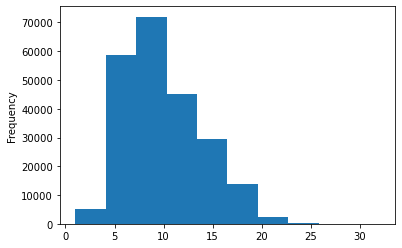

In [24]:
data['code'].str.len().plot.hist()

In [25]:
code_max_len = data['code'].str.len().max()
code_max_len

32

In [26]:
z = [0]*code_max_len
data['code'] = data['code'].progress_apply(lambda c: c+z[:(code_max_len-len(c))]  )

100%|██████████| 226831/226831 [00:00<00:00, 453194.14it/s]


In [27]:
x = np.stack( data['code'].values).astype(int)
x.shape

(226831, 32)

In [28]:
# x = np.flip(x,axis=1)

In [29]:
n_classes=2
target = data['ttype'].values
target = (target+1)//2
y = np.eye(n_classes)[target]

y.shape

(226831, 2)

In [30]:
max_word = x.max()
seq_len = x.shape[1]
x.shape , y.shape, max_word, seq_len

((226831, 32), (226831, 2), 239517, 32)

In [31]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=.4 )
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((136098, 32), (136098, 2), (90733, 32), (90733, 2))

In [32]:
y_train.sum(axis=0),y_test.sum(axis=0),

(array([66988., 69110.]), array([44934., 45799.]))

## строим нейросеть 

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
#from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Dense

In [41]:
embedding_size = 64

model = Sequential()
model.add(Embedding( input_dim = max_word+1, output_dim = embedding_size, input_length = seq_len,))
# model.add(LSTM(32))
model.add(Conv1D(filters=32,padding='same',kernel_size=5))
model.add(GlobalMaxPooling1D())
model.add(Dense(n_classes, activation='softmax'))

In [42]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

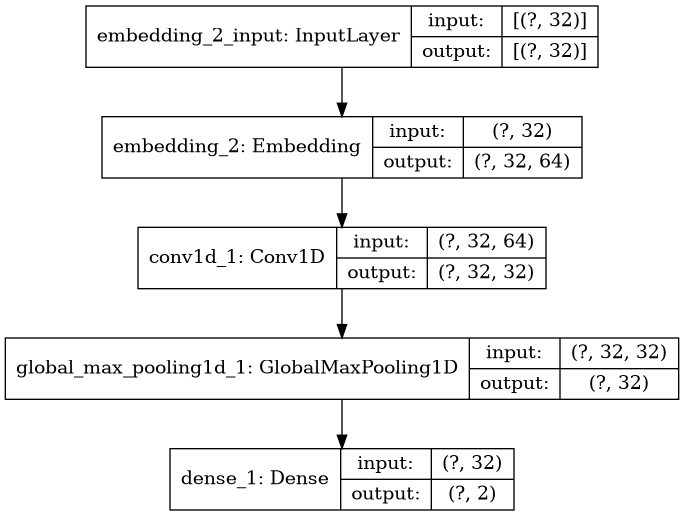

In [43]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_layer_names=True, show_shapes=True )

In [44]:
%%time

hist = model.fit(x_train,y_train, batch_size=1024, epochs=9, validation_split=.3)

Epoch 1/9
94/94 [==============================] - 7s 78ms/step - loss: 0.3975 - accuracy: 0.8468 - val_loss: 0.2152 - val_accuracy: 0.8900
Epoch 2/9
94/94 [==============================] - 7s 75ms/step - loss: 0.1535 - accuracy: 0.9382 - val_loss: 0.2068 - val_accuracy: 0.8926
Epoch 3/9
94/94 [==============================] - 7s 76ms/step - loss: 0.0756 - accuracy: 0.9756 - val_loss: 0.2321 - val_accuracy: 0.8905
Epoch 4/9
94/94 [==============================] - 7s 76ms/step - loss: 0.0351 - accuracy: 0.9909 - val_loss: 0.2672 - val_accuracy: 0.8889
Epoch 5/9
94/94 [==============================] - 7s 76ms/step - loss: 0.0173 - accuracy: 0.9964 - val_loss: 0.3011 - val_accuracy: 0.8870
Epoch 6/9
94/94 [==============================] - 7s 76ms/step - loss: 0.0100 - accuracy: 0.9982 - val_loss: 0.3292 - val_accuracy: 0.8859
Epoch 7/9
94/94 [==============================] - 7s 76ms/step - loss: 0.0058 - accuracy: 0.9992 - val_loss: 0.3571 - val_accuracy: 0.8853
Epoch 8/9
94/94 [===

In [45]:
model.evaluate(x_test ,y_test )

2836/2836 [==============================] - 3s 924us/step - loss: 0.3878 - accuracy: 0.8867


[0.38777878880500793, 0.8867446184158325]

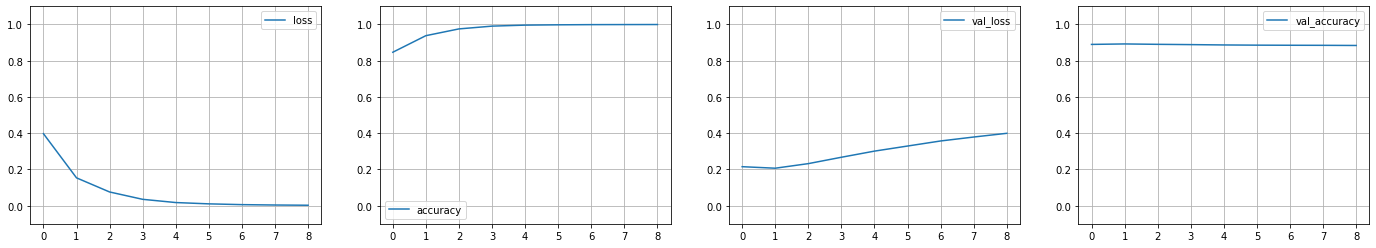

In [46]:
from matplotlib import pyplot as plt

k = hist.history.keys()

w,h = 6,4

fig,ax = plt.subplots(1,len(k),figsize=(w*len(k),h))
for i,n in enumerate(k):
    ax[i].plot(hist.history[n],label=n)
    ax[i].grid(True)
    ax[i].legend()
    ax[i].set_ylim([-.1,1.1])